# Comparing Networks

In this notebook, we want to compare different network to each other.
We will start of with...

- Untrained Model
- Trained Model
- Trained Model (Exact Unlearning)*$^1$

All these model should serve as comparison point for approximate MU Algorithms, which we want to try out

*$^1$ Exact Unlearning: refers to an complete retraining of the Model, without the samples which we want to unlearn.

In [48]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np

from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet
from training import main, train_n_models
from helper import load_models_dict

USED_DATASET = "fashion_mnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

#########################
ALLREADY_TRAINED = True # <--- The Switch
#########################

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= False,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)
len(unlearned_data)

373

In [49]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

We want to include an untrained model as a pour reference point.

Later, we will compare the differently trained (and untrained) models on different metrics. We are thinking, that the **untrained model should always be the furthest neighbor** and see if thats true. Also out of pur curiosity, how do the models compare according to the found metrics to the untrained model.

It could be interesting to see, if the unlearned models tend to be more similar to the "Exact MU Model" or to the "Untrained Model"

The "Trained Model"´s and "Exact Model"´s starting point is the "Untrained Model". That means all models can be traced back to it.

In [50]:
from training import save_model

if not ALLREADY_TRAINED:
    untrained_model = TwoLayerPerceptron() if USED_DATASET in ["mnist", "fashion_mnist"] else ConvNet()
    # save it first
    save_model(untrained_model, name="showcase_untrained", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained", logs=False)

    untrained_ms = {v: TwoLayerPerceptron() for v in range(30)} if USED_DATASET in ["mnist", "fashion_mnist"] else {v: ConvNet() for v in range(30)}

    for i, model in untrained_ms.items():
        save_model(model=model, name=i, path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        untrained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        untrained_showcase_all = ConvNet()
    name = str(untrained_showcase_all)
    untrained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained", map_location=DEVICE,
            weights_only=True
            )
        )
    untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model

This model will be the starting point for all MU algorithms. The more it is important that it does not change throughout the experiments, otherwise we need to run everything again.

Notes Regarding the Dataloader: We included Up-/Downsampling. There is a counter in the Dataset class, which controls, which class is next to provide a sample. From the available pool a sample will be chosen at random.

Reason: The amount of available samples should not influence the performance of the model on certain classes.

Regarding the samples for the class "7": There are more samples of sevens without a middle line than ones with.

Ratio: 
- 6268 (train: 5385, test: 883) 7
- 1025 (train: 880,  test: 145) 7e

Should there be concerns regarding that the bigger part of the sevens (without middle line) will be unlearning?

In [51]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_all = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="all",
        balanced=True,
        dataset_name=USED_DATASET,
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_all = ConvNet()
    name = str(trained_showcase_all)
    trained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [52]:
if not ALLREADY_TRAINED:
    trained_ms = train_n_models(
        sampling_mode="all",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Exact Unlearned Model

This model has the same training conditions as the "Trained Model", with the only difference being, that it had no sevens __with no middle line__

In [53]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_except = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="except_erased",
        balanced=True,
        dataset_name=USED_DATASET,
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_except= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_except = ConvNet()
    name = str(trained_showcase_except)
    trained_showcase_except.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [54]:
if not ALLREADY_TRAINED:
    exact_ms = train_n_models(
        sampling_mode="except_erased",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

## Metrics

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [55]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Unlearn to ...

In [56]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

28.003110107282797

In [57]:
# ...exact model
a12 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a12

27.96686388415595

#### Trained to ...

In [58]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a21

29.06532600025336

In [59]:
calc_mutlimodel_metric_average(modeltype1=trained_ms, modeltype2=trained_ms, metric="l2_norm")

0.0

#### Exact to ...

In [60]:
# see above

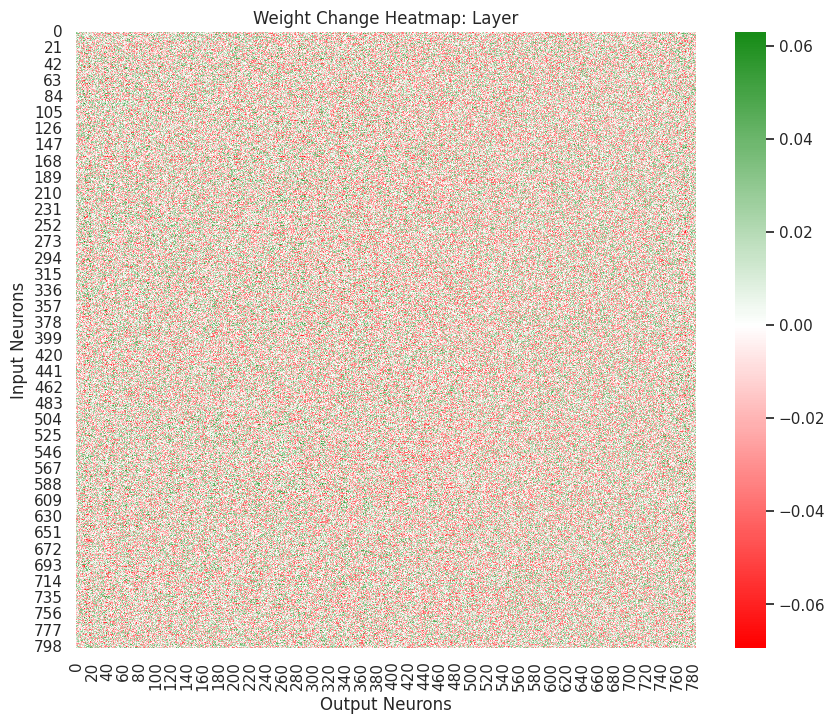

In [61]:
from visualize import visualize_weight_change

visualize_weight_change(weights_before=trained_ms[0].fc1.weight, weights_after=torch.zeros_like(exact_ms[0].fc1.weight))

### Layer-wise Comparison

In [62]:
from metrics import model_layer_wise_difference
lw_dist = {}
for t, mu in zip(trained_ms.values(), exact_ms.values()):
    new = model_layer_wise_difference(t, mu)
    if len(lw_dist) == 0:
        for name in new.keys():
            lw_dist[name] = []
    for name in new.keys():
        lw_dist[name].append(new[name])
for key in lw_dist.keys():
    lw_dist[key] = sum(lw_dist[key])/len(lw_dist[key])
lw_dist

{'fc1.weight': 15738.618391927082,
 'fc1.bias': 22.738258616129556,
 'fc3.weight': 259.9481252034505,
 'fc3.bias': 0.23307233452796935}

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [63]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader
dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [64]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.4592808586485846

In [65]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.0678693705416742

#### Trained to...

In [66]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.6345665979892643

In [67]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.6528788426772077

#### Exact to...

In [68]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.8268310403992947

In [69]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.6479388496131763

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [70]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.1004 - Standard Deviation for D_gesamt: 0.0290


Average Accuracy for D_remain: 0.1005 - Standard Deviation for D_remain: 0.0292


Average Accuracy for 0: 0.0763 - Standard Deviation for 0: 0.2055


Average Accuracy for 1: 0.1518 - Standard Deviation for 1: 0.3020


Average Accuracy for 2: 0.1308 - Standard Deviation for 2: 0.2224


Average Accuracy for 3: 0.1450 - Standard Deviation for 3: 0.2875


Average Accuracy for 4: 0.0607 - Standard Deviation for 4: 0.1322


Average Accuracy for 6: 0.0238 - Standard Deviation for 6: 0.0511


Average Accuracy for 7: 0.0833 - Standard Deviation for 7: 0.1600


Average Accuracy for 8: 0.1141 - Standard Deviation for 8: 0.2162


Average Accuracy for 9: 0.1341 - Standard Deviation for 9: 0.2474


Average Accuracy for 5_all: 0.0839 - Standard Deviation for 5_all: 0.1442


Average Accuracy for 5_remain: 0.0771 - Standard Deviation for 5_remain: 0.1333


Average Accuracy for 5_erased: 0.0967 - Standard Deviation for 5_erased: 0.1873
plotting...


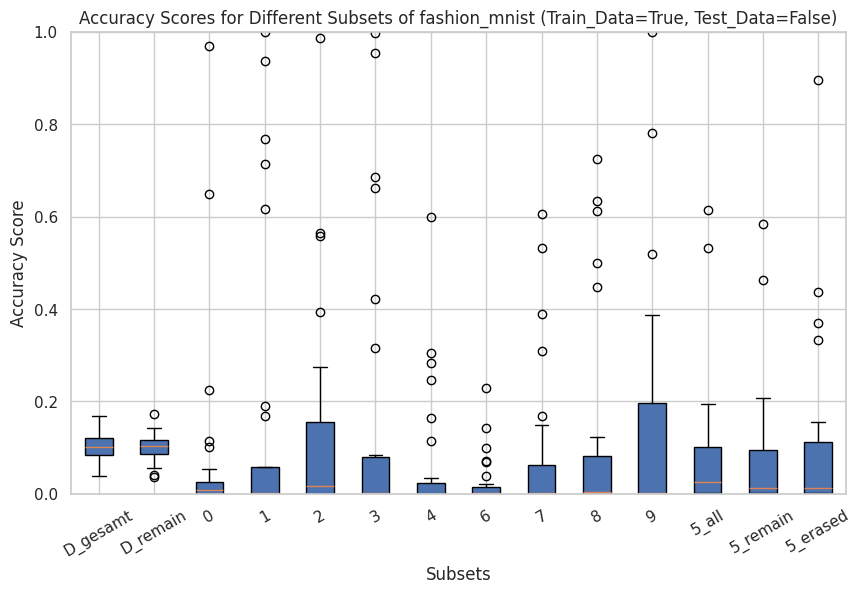

In [71]:
accs["untrained_ms_train"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.1002 - Standard Deviation for D_gesamt: 0.0297


Average Accuracy for D_remain: 0.1003 - Standard Deviation for D_remain: 0.0301


Average Accuracy for 0: 0.0759 - Standard Deviation for 0: 0.2049


Average Accuracy for 1: 0.1527 - Standard Deviation for 1: 0.3013


Average Accuracy for 2: 0.1285 - Standard Deviation for 2: 0.2204


Average Accuracy for 3: 0.1461 - Standard Deviation for 3: 0.2877


Average Accuracy for 4: 0.0576 - Standard Deviation for 4: 0.1238


Average Accuracy for 6: 0.0234 - Standard Deviation for 6: 0.0504


Average Accuracy for 7: 0.0820 - Standard Deviation for 7: 0.1618


Average Accuracy for 8: 0.1163 - Standard Deviation for 8: 0.2233


Average Accuracy for 9: 0.1350 - Standard Deviation for 9: 0.2480


Average Accuracy for 5_all: 0.0848 - Standard Deviation for 5_all: 0.1478


Average Accuracy for 5_remain: 0.0775 - Standard Deviation for 5_remain: 0.1354


Average Accuracy for 5_erased: 0.0971 - Standard Deviation for 5_erased: 0.1892
plotting...


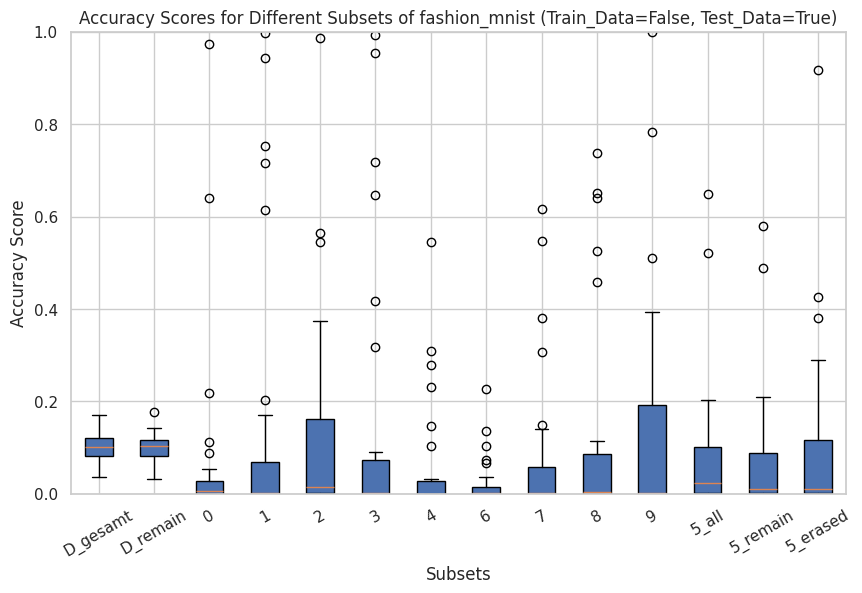

In [72]:
accs["untrained_ms_test"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.8082 - Standard Deviation for D_gesamt: 0.0011


Average Accuracy for D_remain: 0.8051 - Standard Deviation for D_remain: 0.0011


Average Accuracy for 0: 0.8097 - Standard Deviation for 0: 0.0072


Average Accuracy for 1: 0.9384 - Standard Deviation for 1: 0.0011


Average Accuracy for 2: 0.6762 - Standard Deviation for 2: 0.0099


Average Accuracy for 3: 0.8684 - Standard Deviation for 3: 0.0048


Average Accuracy for 4: 0.7877 - Standard Deviation for 4: 0.0131


Average Accuracy for 6: 0.4408 - Standard Deviation for 6: 0.0154


Average Accuracy for 7: 0.8927 - Standard Deviation for 7: 0.0039


Average Accuracy for 8: 0.9362 - Standard Deviation for 8: 0.0024


Average Accuracy for 9: 0.9267 - Standard Deviation for 9: 0.0027


Average Accuracy for 5_all: 0.8048 - Standard Deviation for 5_all: 0.0078


Average Accuracy for 5_remain: 0.7575 - Standard Deviation for 5_remain: 0.0105


Average Accuracy for 5_erased: 0.8929 - Standard Deviation for 5_erased: 0.0053
plotting...


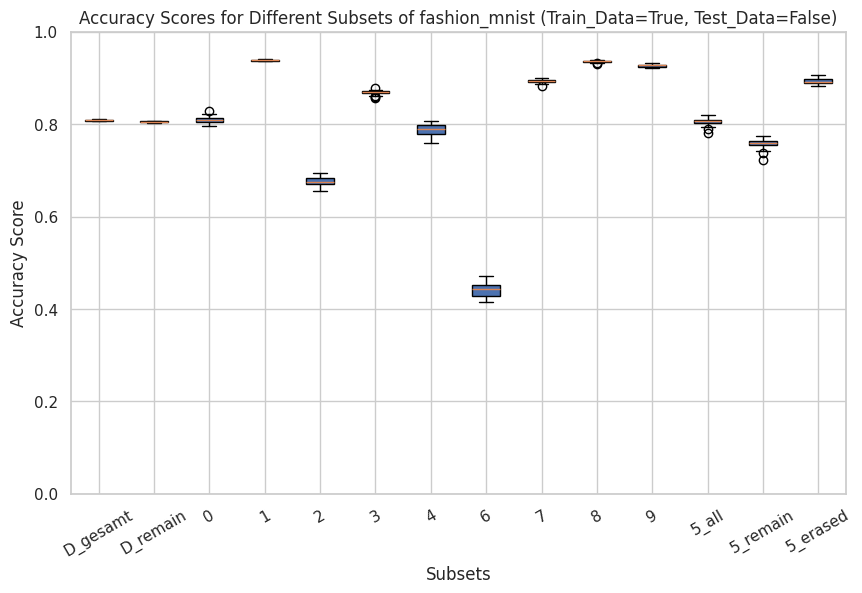

In [73]:
accs["trained_ms_train"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.7953 - Standard Deviation for D_gesamt: 0.0011


Average Accuracy for D_remain: 0.7921 - Standard Deviation for D_remain: 0.0011


Average Accuracy for 0: 0.7870 - Standard Deviation for 0: 0.0072


Average Accuracy for 1: 0.9306 - Standard Deviation for 1: 0.0014


Average Accuracy for 2: 0.6537 - Standard Deviation for 2: 0.0104


Average Accuracy for 3: 0.8559 - Standard Deviation for 3: 0.0051


Average Accuracy for 4: 0.7602 - Standard Deviation for 4: 0.0163


Average Accuracy for 6: 0.4165 - Standard Deviation for 6: 0.0135


Average Accuracy for 7: 0.8912 - Standard Deviation for 7: 0.0055


Average Accuracy for 8: 0.9376 - Standard Deviation for 8: 0.0027


Average Accuracy for 9: 0.9337 - Standard Deviation for 9: 0.0031


Average Accuracy for 5_all: 0.7868 - Standard Deviation for 5_all: 0.0074


Average Accuracy for 5_remain: 0.7327 - Standard Deviation for 5_remain: 0.0095


Average Accuracy for 5_erased: 0.8777 - Standard Deviation for 5_erased: 0.0071
plotting...


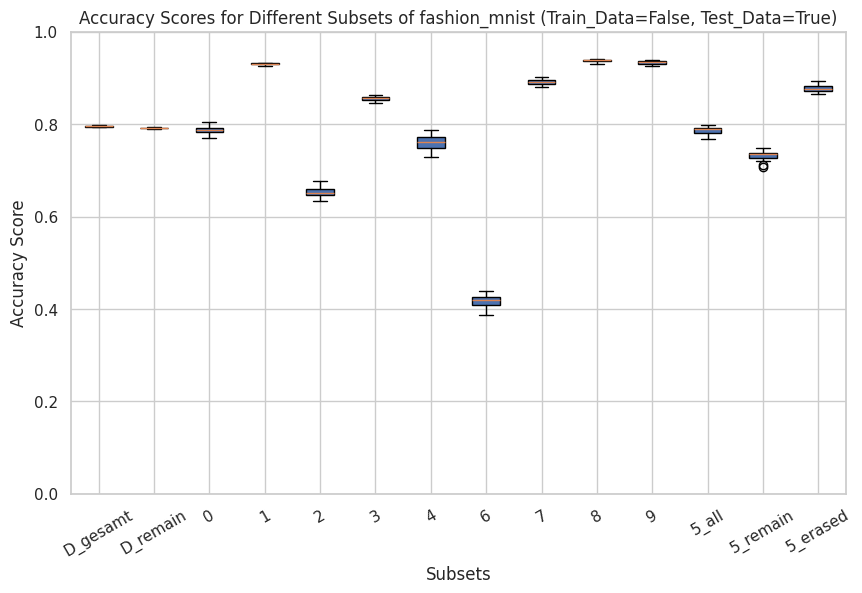

In [74]:
accs["trained_ms_test"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.7866 - Standard Deviation for D_gesamt: 0.0012


Average Accuracy for D_remain: 0.8073 - Standard Deviation for D_remain: 0.0011


Average Accuracy for 0: 0.8117 - Standard Deviation for 0: 0.0073


Average Accuracy for 1: 0.9390 - Standard Deviation for 1: 0.0014


Average Accuracy for 2: 0.6767 - Standard Deviation for 2: 0.0097


Average Accuracy for 3: 0.8689 - Standard Deviation for 3: 0.0056


Average Accuracy for 4: 0.7927 - Standard Deviation for 4: 0.0114


Average Accuracy for 6: 0.4277 - Standard Deviation for 6: 0.0150


Average Accuracy for 7: 0.8798 - Standard Deviation for 7: 0.0049


Average Accuracy for 8: 0.9346 - Standard Deviation for 8: 0.0020


Average Accuracy for 9: 0.9309 - Standard Deviation for 9: 0.0026


Average Accuracy for 5_all: 0.6038 - Standard Deviation for 5_all: 0.0080


Average Accuracy for 5_remain: 0.8135 - Standard Deviation for 5_remain: 0.0054


Average Accuracy for 5_erased: 0.2135 - Standard Deviation for 5_erased: 0.0153
plotting...


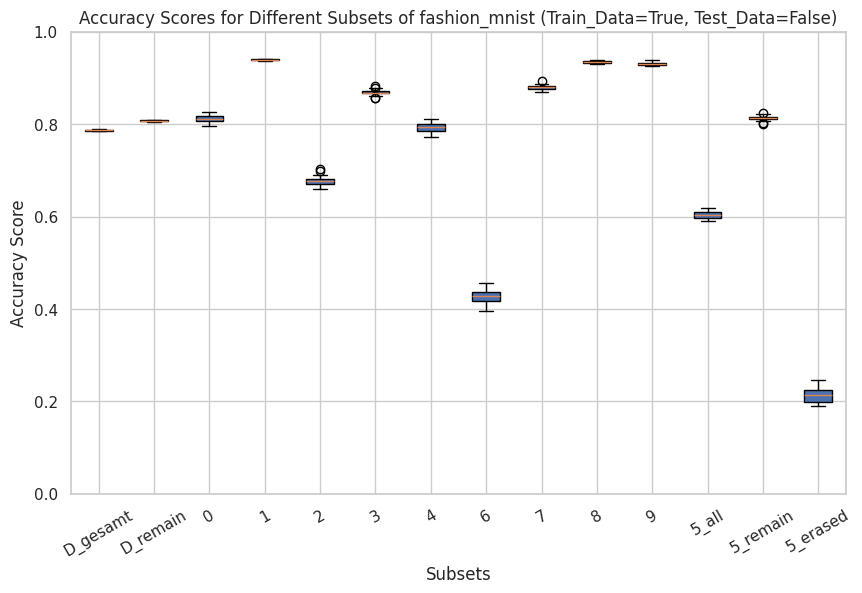

In [75]:
accs["exact_ms_train"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.7730 - Standard Deviation for D_gesamt: 0.0014


Average Accuracy for D_remain: 0.7945 - Standard Deviation for D_remain: 0.0011


Average Accuracy for 0: 0.7894 - Standard Deviation for 0: 0.0080


Average Accuracy for 1: 0.9309 - Standard Deviation for 1: 0.0013


Average Accuracy for 2: 0.6530 - Standard Deviation for 2: 0.0120


Average Accuracy for 3: 0.8581 - Standard Deviation for 3: 0.0067


Average Accuracy for 4: 0.7697 - Standard Deviation for 4: 0.0158


Average Accuracy for 6: 0.4056 - Standard Deviation for 6: 0.0128


Average Accuracy for 7: 0.8829 - Standard Deviation for 7: 0.0051


Average Accuracy for 8: 0.9358 - Standard Deviation for 8: 0.0020


Average Accuracy for 9: 0.9362 - Standard Deviation for 9: 0.0025


Average Accuracy for 5_all: 0.5682 - Standard Deviation for 5_all: 0.0101


Average Accuracy for 5_remain: 0.7769 - Standard Deviation for 5_remain: 0.0069


Average Accuracy for 5_erased: 0.2173 - Standard Deviation for 5_erased: 0.0183
plotting...


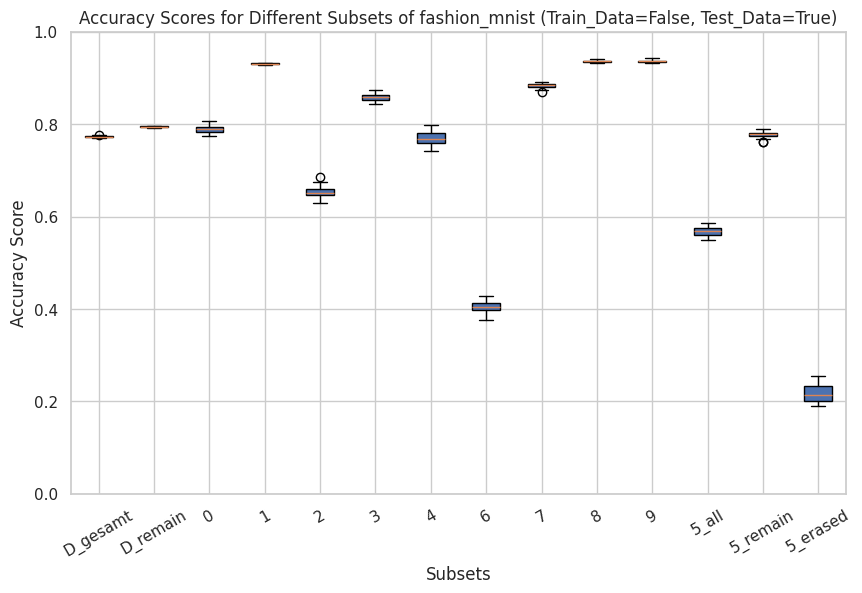

In [76]:
accs["exact_ms_test"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

#### Losses

In [77]:
losses = {}

In [78]:
losses["untrained_ms_train"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


KeyboardInterrupt: 

Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.2880 - Standard Deviation for D_gesamt: 0.0001


Average Loss for D_remain: 0.2881 - Standard Deviation for D_remain: 0.0002


Average Loss for 0: 0.2889 - Standard Deviation for 0: 0.0067


Average Loss for 1: 0.2879 - Standard Deviation for 1: 0.0065


Average Loss for 2: 0.2846 - Standard Deviation for 2: 0.0054


Average Loss for 3: 0.2912 - Standard Deviation for 3: 0.0075


Average Loss for 4: 0.2885 - Standard Deviation for 4: 0.0076


Average Loss for 5: 0.2907 - Standard Deviation for 5: 0.0060


Average Loss for 6: 0.2904 - Standard Deviation for 6: 0.0065


Average Loss for 8: 0.2888 - Standard Deviation for 8: 0.0052


Average Loss for 9: 0.2917 - Standard Deviation for 9: 0.0064


Average Loss for 7_all: 0.2866 - Standard Deviation for 7_all: 0.0069


Average Loss for 7_remain: 0.2874 - Standard Deviation for 7_remain: 0.0069


Average Loss for 7_erased: 0.2979 - Standard Deviation for 7_erased: 0.0073
plotting...


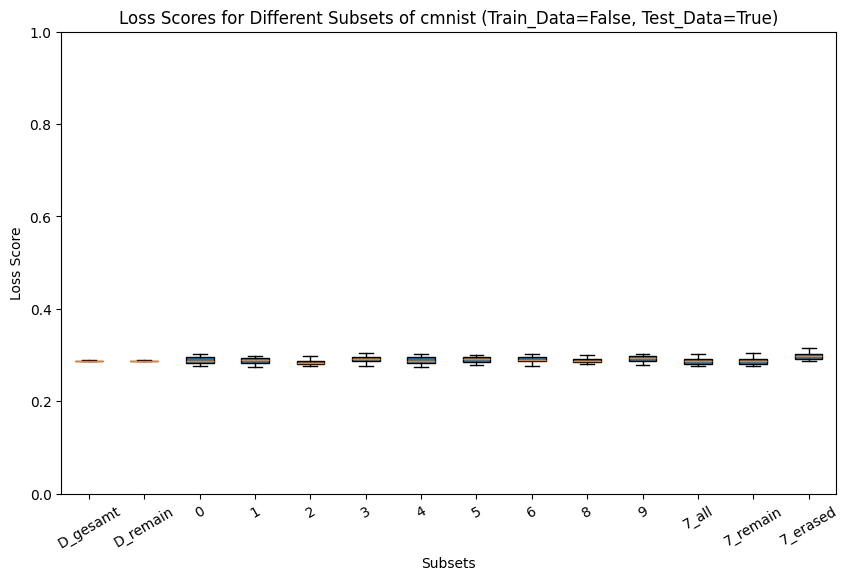

In [ ]:
losses["untrained_ms_test"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.0329 - Standard Deviation for D_gesamt: 0.0019


Average Loss for D_remain: 0.0318 - Standard Deviation for D_remain: 0.0018


Average Loss for 0: 0.0160 - Standard Deviation for 0: 0.0030


Average Loss for 1: 0.0233 - Standard Deviation for 1: 0.0030


Average Loss for 2: 0.0360 - Standard Deviation for 2: 0.0055


Average Loss for 3: 0.0435 - Standard Deviation for 3: 0.0085


Average Loss for 4: 0.0280 - Standard Deviation for 4: 0.0045


Average Loss for 5: 0.0333 - Standard Deviation for 5: 0.0049


Average Loss for 6: 0.0188 - Standard Deviation for 6: 0.0030


Average Loss for 8: 0.0448 - Standard Deviation for 8: 0.0062


Average Loss for 9: 0.0509 - Standard Deviation for 9: 0.0061


Average Loss for 7_all: 0.0369 - Standard Deviation for 7_all: 0.0063


Average Loss for 7_remain: 0.0260 - Standard Deviation for 7_remain: 0.0050


Average Loss for 7_erased: 0.1115 - Standard Deviation for 7_erased: 0.0170
plotting...


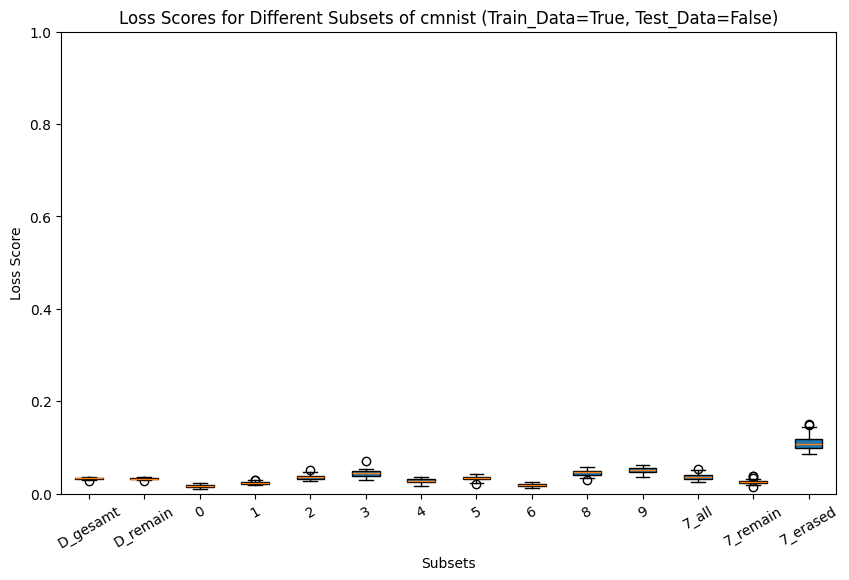

In [ ]:
losses["trained_ms_train"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.0336 - Standard Deviation for D_gesamt: 0.0019


Average Loss for D_remain: 0.0318 - Standard Deviation for D_remain: 0.0018


Average Loss for 0: 0.0130 - Standard Deviation for 0: 0.0026


Average Loss for 1: 0.0171 - Standard Deviation for 1: 0.0028


Average Loss for 2: 0.0363 - Standard Deviation for 2: 0.0055


Average Loss for 3: 0.0368 - Standard Deviation for 3: 0.0076


Average Loss for 4: 0.0341 - Standard Deviation for 4: 0.0052


Average Loss for 5: 0.0367 - Standard Deviation for 5: 0.0051


Average Loss for 6: 0.0224 - Standard Deviation for 6: 0.0037


Average Loss for 8: 0.0490 - Standard Deviation for 8: 0.0064


Average Loss for 9: 0.0499 - Standard Deviation for 9: 0.0059


Average Loss for 7_all: 0.0427 - Standard Deviation for 7_all: 0.0065


Average Loss for 7_remain: 0.0244 - Standard Deviation for 7_remain: 0.0047


Average Loss for 7_erased: 0.1744 - Standard Deviation for 7_erased: 0.0223
plotting...


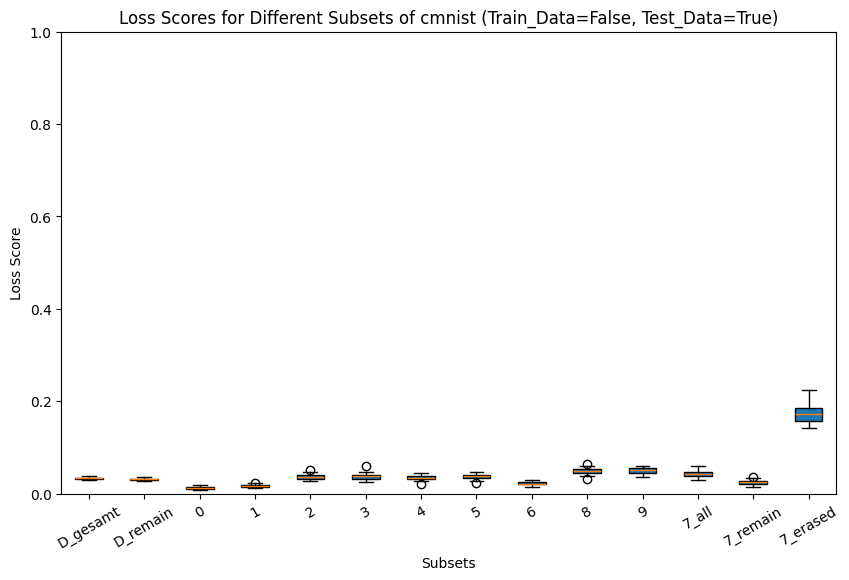

In [ ]:
losses["trained_ms_test"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.0348 - Standard Deviation for D_gesamt: 0.0022


Average Loss for D_remain: 0.0315 - Standard Deviation for D_remain: 0.0021


Average Loss for 0: 0.0165 - Standard Deviation for 0: 0.0026


Average Loss for 1: 0.0224 - Standard Deviation for 1: 0.0031


Average Loss for 2: 0.0348 - Standard Deviation for 2: 0.0060


Average Loss for 3: 0.0426 - Standard Deviation for 3: 0.0064


Average Loss for 4: 0.0292 - Standard Deviation for 4: 0.0037


Average Loss for 5: 0.0323 - Standard Deviation for 5: 0.0055


Average Loss for 6: 0.0204 - Standard Deviation for 6: 0.0040


Average Loss for 8: 0.0448 - Standard Deviation for 8: 0.0071


Average Loss for 9: 0.0491 - Standard Deviation for 9: 0.0078


Average Loss for 7_all: 0.0564 - Standard Deviation for 7_all: 0.0072


Average Loss for 7_remain: 0.0251 - Standard Deviation for 7_remain: 0.0045


Average Loss for 7_erased: 0.2659 - Standard Deviation for 7_erased: 0.0330
plotting...


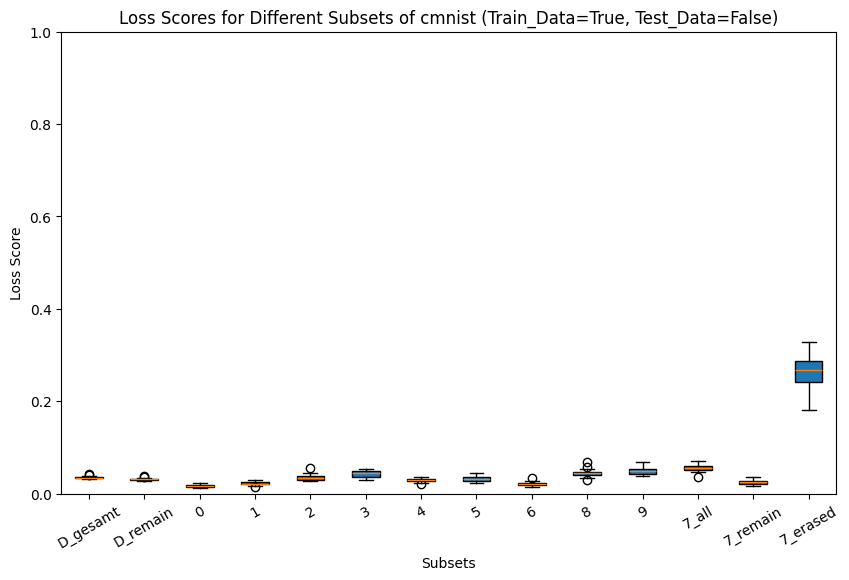

In [ ]:
losses["exact_ms_train"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.0358 - Standard Deviation for D_gesamt: 0.0023


Average Loss for D_remain: 0.0317 - Standard Deviation for D_remain: 0.0022


Average Loss for 0: 0.0134 - Standard Deviation for 0: 0.0021


Average Loss for 1: 0.0162 - Standard Deviation for 1: 0.0027


Average Loss for 2: 0.0349 - Standard Deviation for 2: 0.0068


Average Loss for 3: 0.0370 - Standard Deviation for 3: 0.0062


Average Loss for 4: 0.0358 - Standard Deviation for 4: 0.0044


Average Loss for 5: 0.0357 - Standard Deviation for 5: 0.0061


Average Loss for 6: 0.0240 - Standard Deviation for 6: 0.0049


Average Loss for 8: 0.0480 - Standard Deviation for 8: 0.0069


Average Loss for 9: 0.0484 - Standard Deviation for 9: 0.0073


Average Loss for 7_all: 0.0663 - Standard Deviation for 7_all: 0.0075


Average Loss for 7_remain: 0.0249 - Standard Deviation for 7_remain: 0.0040


Average Loss for 7_erased: 0.3568 - Standard Deviation for 7_erased: 0.0429
plotting...


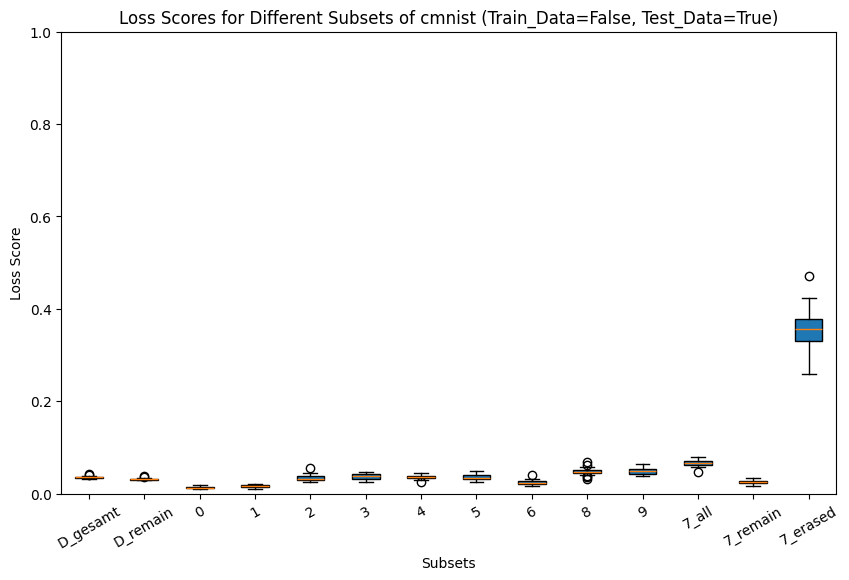

In [ ]:
losses["exact_ms_test"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

___